Подключу необходимые библиотеки и файлы

In [52]:
import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/Yuichir0/Telecom/thinkdsp.py
if not os.path.exists('FB_2.csv'):
    !wget https://github.com/Yuichir0/Telecom/FB_2.csv

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from thinkdsp import decorate, Wave, zero_pad, TriangleSignal, SquareSignal, SawtoothSignal, CubicSignal

## Упражнение 9.1
Блокнот для этой главы - chap09.ipynb. Прочитайте его и запустите код.

В разделе "Нарастающая сумма" на стр. 119 отмечено, что некоторые примеры не работают с апериодическими сигналами. Замените периодический пилообразный сигнал на непериодические данные Facebook и посмотрите, что пойдёт не так.

### Решение
Подготовлю данные к обработке

In [7]:
df = pd.read_csv('FB_2.csv', header=0, parse_dates=[0])
len(df)

1977

In [8]:
ys = df['Close']

if len(ys) % 2:
    ys = ys[:-1]

close = Wave(ys, framerate=1)
len(close)

1976

Построю временной ряд и спектр

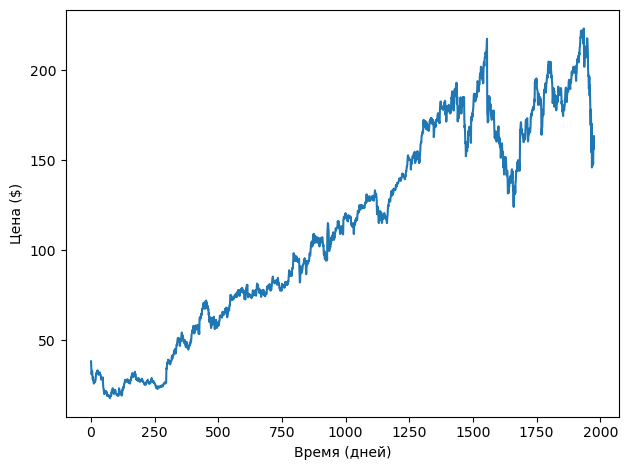

In [10]:
close.plot()
decorate(xlabel='Время (дней)', ylabel='Цена ($)')

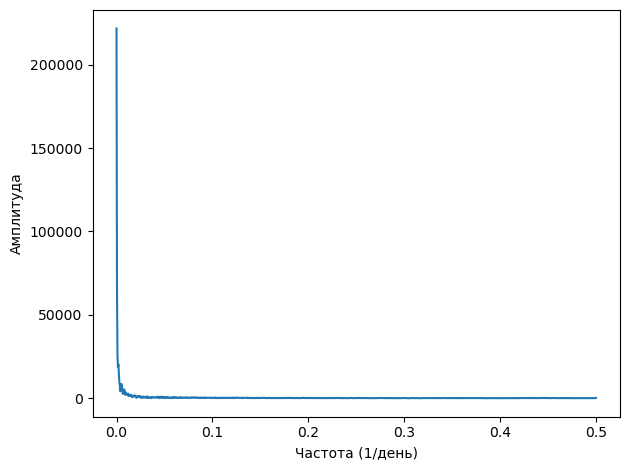

In [11]:
close_spectrum = close.make_spectrum()
close_spectrum.plot()
decorate(xlabel='Частота (1/день)', ylabel='Амплитуда')

Полученная выходная волна - это нарастающая сумма входных сигналов. 
Вычислю спектр

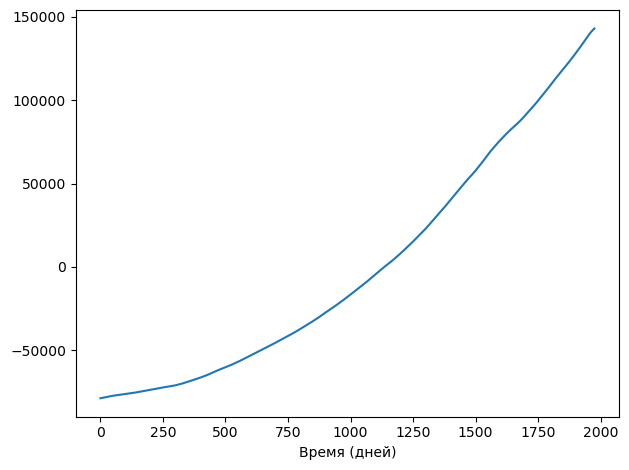

In [12]:
out_wave = close.cumsum()
out_wave.unbias()
out_wave.plot()
decorate(xlabel='Время (дней)')

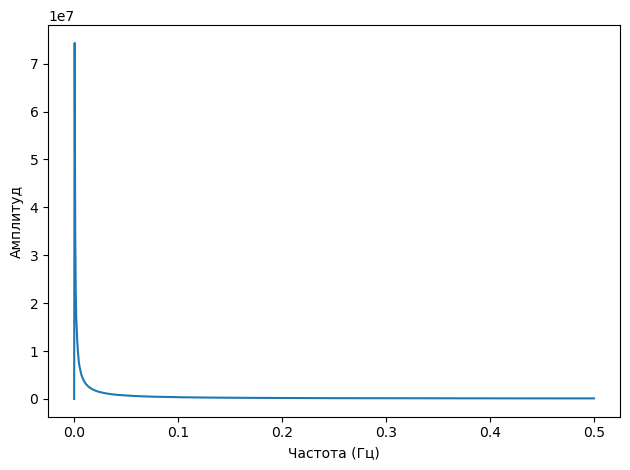

In [13]:
out_spectrum = out_wave.make_spectrum()
out_spectrum.plot()
decorate(xlabel='Частота (Гц)', ylabel='Амплитуд')

Вычислю отношение выходных данных к входным:

In [14]:
sum(close_spectrum.amps < 1), len(close_spectrum)

(0, 989)

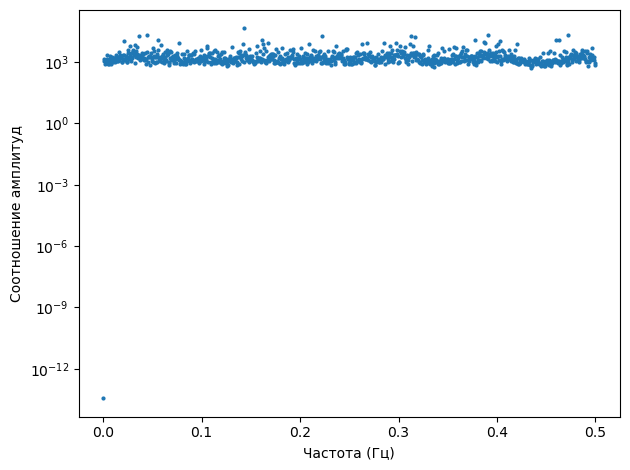

In [16]:
ratio_spectrum = out_spectrum.ratio(close_spectrum, thresh=1)
ratio_spectrum.plot(marker='.', ms=4, ls='')

decorate(xlabel='Частота (Гц)', ylabel='Соотношение амплитуд', yscale='log')

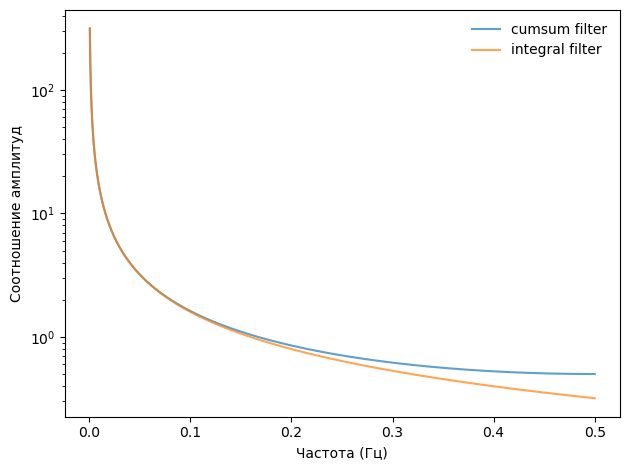

In [19]:
diff_window = np.array([1.0, -1.0])
padded = zero_pad(diff_window, len(close))
diff_wave = Wave(padded, framerate=close.framerate)
diff_filter = diff_wave.make_spectrum()

cumsum_filter = diff_filter.copy()
cumsum_filter.hs[1:] = 1 / cumsum_filter.hs[1:]
cumsum_filter.hs[0] = np.inf

integ_filter = cumsum_filter.copy()
integ_filter.hs[1:] = integ_filter.framerate / (np.pi*2 * 1j * integ_filter.fs[1:])
integ_filter.hs[0] = np.inf

cumsum_filter.plot(label='cumsum filter', alpha=0.7)
integ_filter.plot(label='integral filter', alpha=0.7)

decorate(xlabel='Частота (Гц)', ylabel='Соотношение амплитуд', yscale='log')

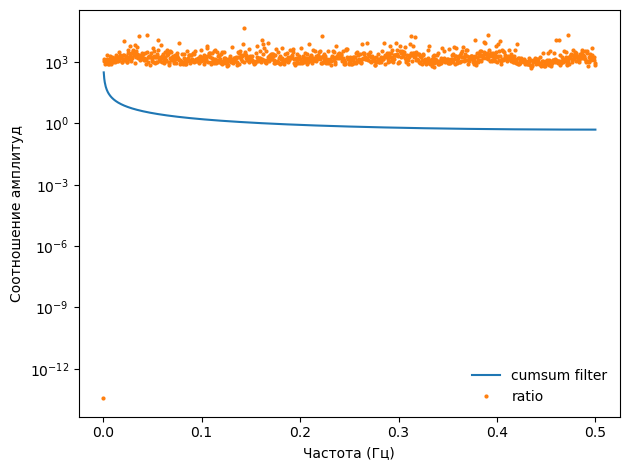

In [20]:
cumsum_filter.plot(label='cumsum filter')
ratio_spectrum.plot(label='ratio', marker='.', ms=4, ls='')
decorate(xlabel='Частота (Гц)', ylabel='Соотношение амплитуд', yscale='log')

Теперь вычислю выходную волну, используя теорему о свертке, и сравню результаты

In [21]:
len(close_spectrum), len(cumsum_filter)

(989, 989)

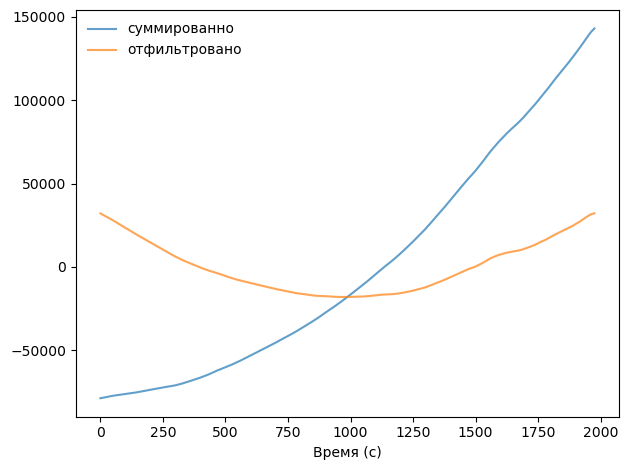

In [23]:
out_wave.plot(label='суммированно', alpha=0.7)

cumsum_filter.hs[0] = 0
out_wave2 = (close_spectrum * cumsum_filter).make_wave()
out_wave2.plot(label='отфильтровано', alpha=0.7)

decorate(xlabel='Время (с)')

In [24]:
out_wave.max_diff(out_wave2)

110808.40936477095

Полученные результаты практически противоположны

### Упражнение 9.2
В этом упражнение изучается влияение diff и differentiate на сигнал. 
Создайте треугольный сигнал и напечатайте его. 
Примените diff к сигналу и напечатайте результат. 
Вычислите спектр треугольного сигнала, примените differentiate и напечатайте результат. 
Преобразуйте спектр обратно в сигнал и напечатайте его. Есть ли различия в воздействии diff и differentiate на этот сигнал?

### Решение
Создам треугольный сигнал

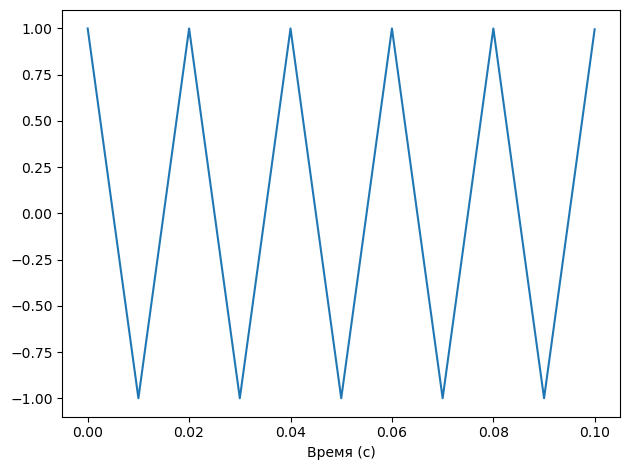

In [30]:
in_wave = TriangleSignal(freq=50).make_wave(duration=0.1, framerate=44100)
in_wave.plot()
decorate(xlabel='Время (с)')

Применю diff

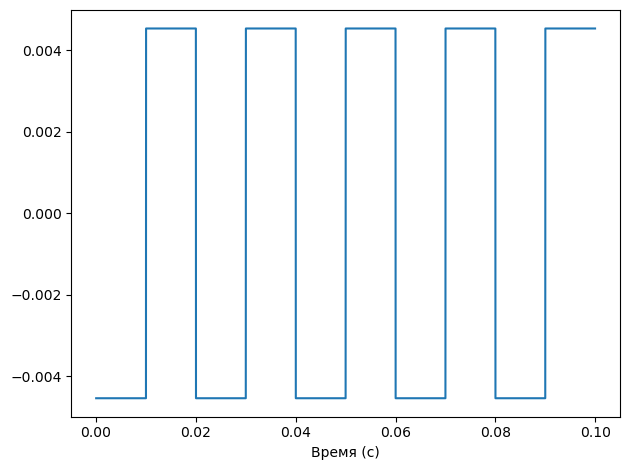

In [31]:
out_wave = in_wave.diff()
out_wave.plot()
decorate(xlabel='Время (с)')

diff от треугольника - прямоугольный сигнал. 
Применю differentiate

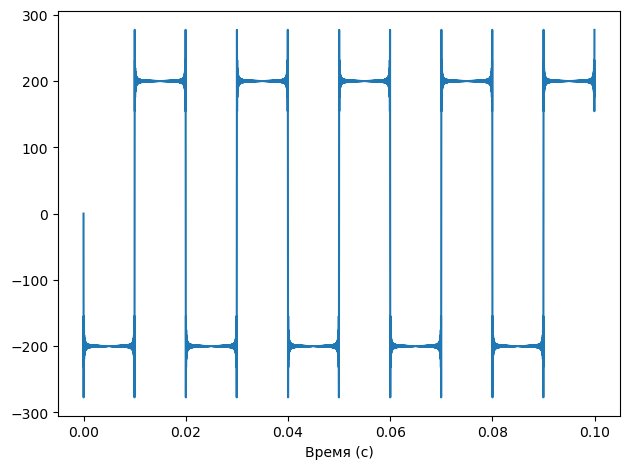

In [32]:
out_wave2 = in_wave.make_spectrum().differentiate().make_wave()
out_wave2.plot()
decorate(xlabel='Время (с)')

Воздействия на треугольный сигнал у этих двух функций действительно разные, так как производная треугольной волны не определена в точках треугольника.

### Упражнение 9.3
В данном упражнении изучается влияние cumsum и integrate на сигнал.
 Создайте прямоугольный сигнал и напечатайте его.
 Примените cumsum и напечатайте результат.
 Вычислите спектр прямоугольного сигнала, примените integrate и напечатайте результат.
 Преобразуйте спектр обратно в сигнал и напечатайте его. Есть ли различия в воздействии cumsum И integrate на этот сигнал?

### Решение
Задание обратно предыдущему

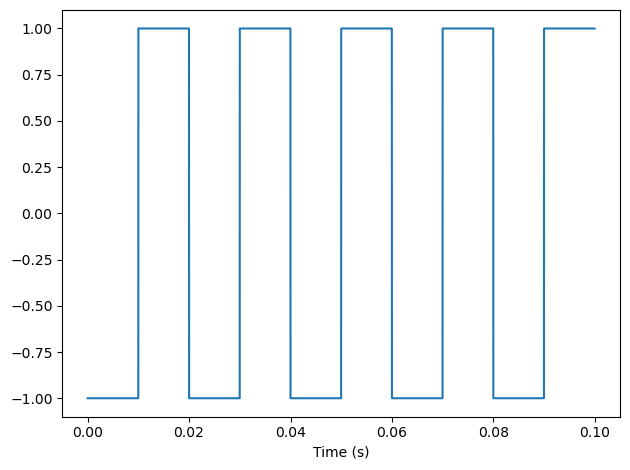

In [34]:
in_wave = SquareSignal(freq=50).make_wave(duration=0.1, framerate=44100)
in_wave.plot()
decorate(xlabel='Время (с)')

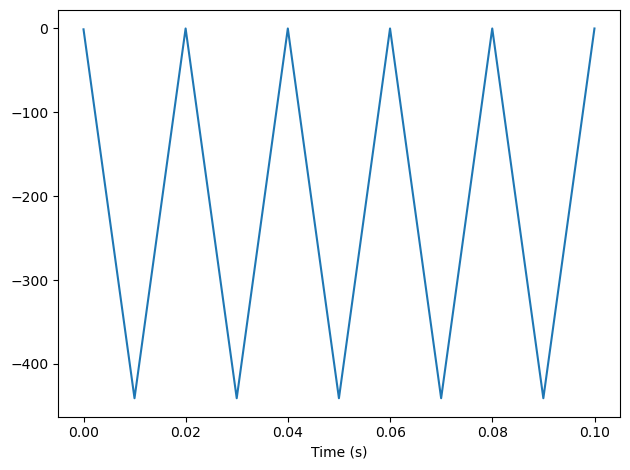

In [35]:
out_wave = in_wave.cumsum()
out_wave.plot()
decorate(xlabel='Время (с)')

Кумулятивная сумма квадратичного сигнала - треугольный сигнал.

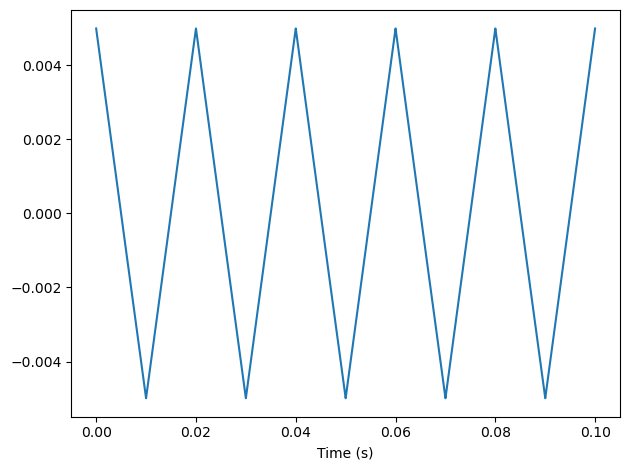

In [36]:
spectrum = in_wave.make_spectrum().integrate()
spectrum.hs[0] = 0
out_wave2 = spectrum.make_wave()
out_wave2.plot()
decorate(xlabel='Время (с)')

Интеграл по спектру - тоже треугольный сигнал, но с сильно отличной амплитудой, визуально они схожи

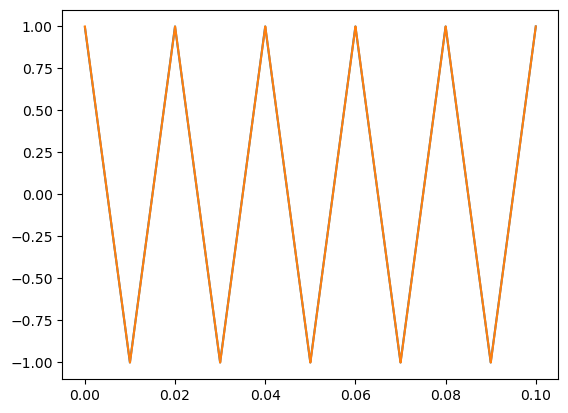

In [38]:
out_wave.unbias()
out_wave.normalize()
out_wave2.normalize()
out_wave.plot()
out_wave2.plot()

In [39]:
out_wave.max_diff(out_wave2)

0.0045351473922902175

По значению они тоже похожи, разница появляется только на 3 цифре после запятой

### Упражнение 9.4
В данном упражнение изучается влияние двойного интегрирования.
 Создайте пилообразный сигнал, вычилите его спектр, а затем дважды примените integrate.
 Напечатайте результирующий сигнал и его спектр.
 Какова математическая форма сигнала? Почему он напоминает синусоиду?

### Решение

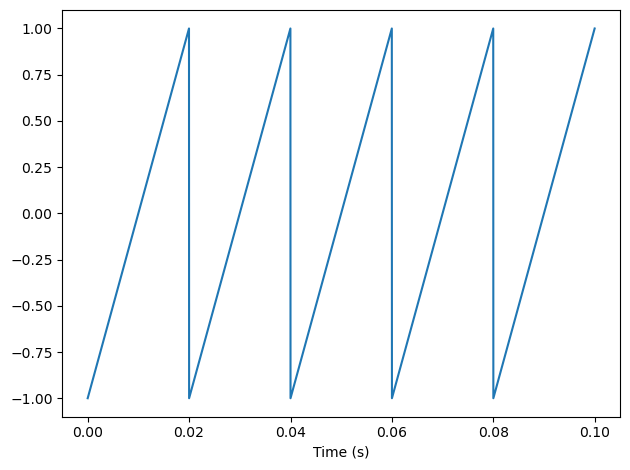

In [42]:
in_wave = SawtoothSignal(freq=50).make_wave(duration=0.1, framerate=44100)
in_wave.plot()
decorate(xlabel='Время (с)')

Первая кумулятивная сумма - парабола

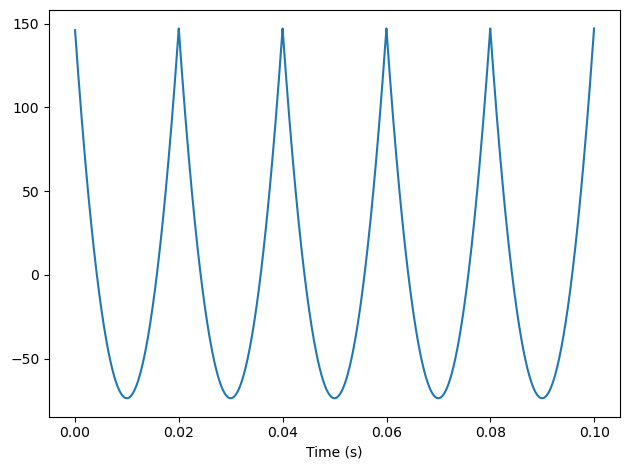

In [47]:
out_wave = in_wave.cumsum()
out_wave.unbias()
out_wave.plot()
decorate(xlabel='Время (с)')

Вторая - кубическая кривая

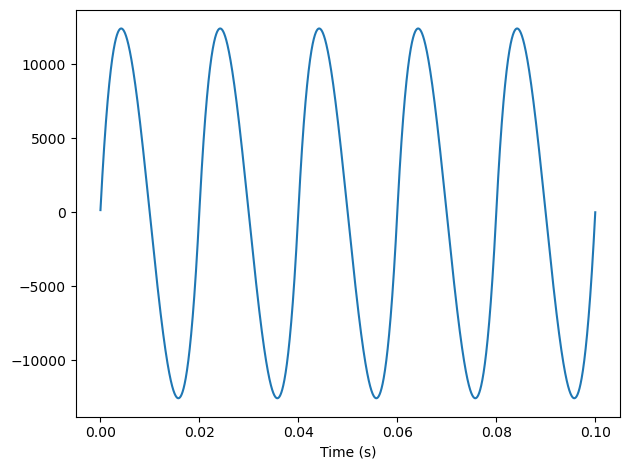

In [48]:
out_wave = out_wave.cumsum()
out_wave.plot()
decorate(xlabel='Время (с)')

Двойное интегрирование тоже дает кубическую кривую

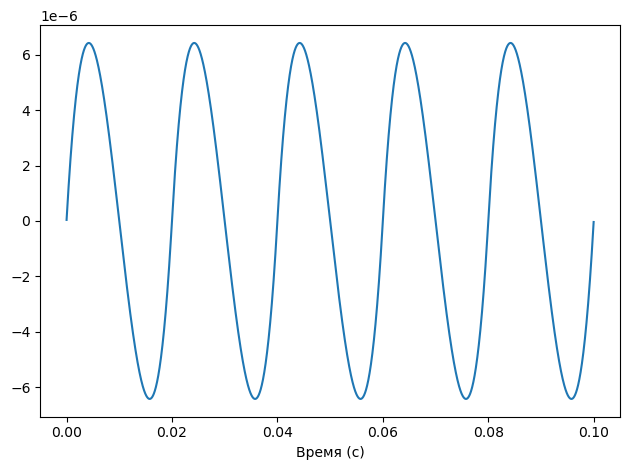

In [49]:
spectrum = in_wave.make_spectrum().integrate().integrate()
spectrum.hs[0] = 0
out_wave2 = spectrum.make_wave()
out_wave2.plot()
decorate(xlabel='Время (с)')

Сигнал сильно напоминает синусоиду. Это произошло из-за того что интегрирование работает похоже на метод low_pass, фильтрующий наш сигнал, в результате чего получается чистая синусоида.
Посмотрим результат на графике

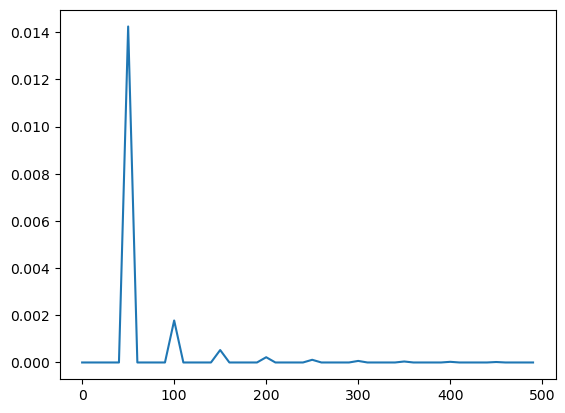

In [51]:
out_wave2.make_spectrum().plot(high=500)

### Упражнение 9.5
В этом упражнении изучается влияние второй разности и второй производной. Создайте CubicSignal, определенный в thinkdsp.
 Вычислите вторую разность, дважды применив diff.
 Как выглядит результат? Вычислите вторую производную, дважды применив differentiate к спектру. Похожи ли результаты?

Распечатайте фильтры, соответствующие второй разнице и второй производной, и сравните их. Подсказка: для того чтобы получить фильтры в одном масштабе, используйте сигнал с частотой кадров 1.

### Решение
Создам кубический сигнал

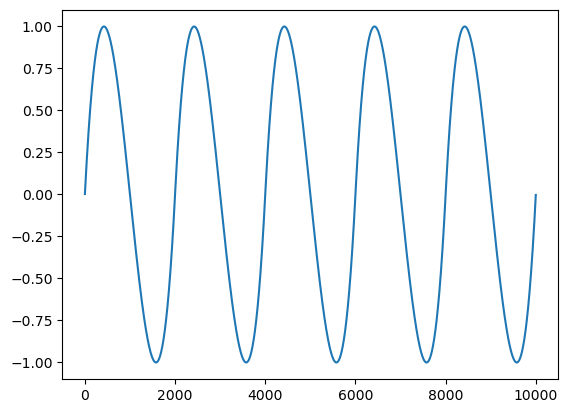

In [53]:
in_wave = CubicSignal(freq=0.0005).make_wave(duration=10000, framerate=1)
in_wave.plot()

Первая разность - парабола, вторая - пилообразный сигнал

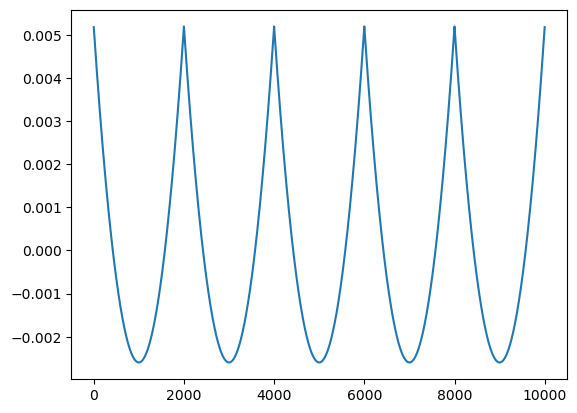

In [54]:
out_wave = in_wave.diff()
out_wave.plot()

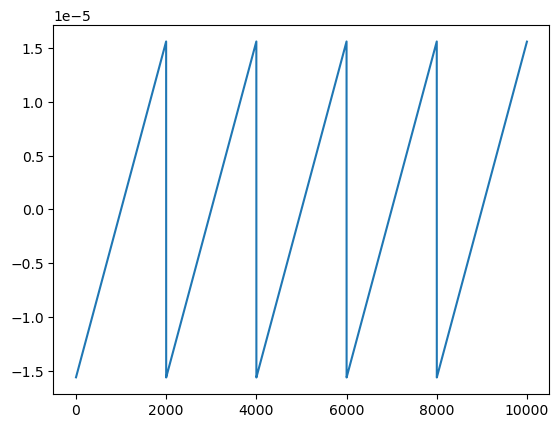

In [55]:
out_wave = out_wave.diff()
out_wave.plot()

Вторая производная - пилообразный сигнал с биениями

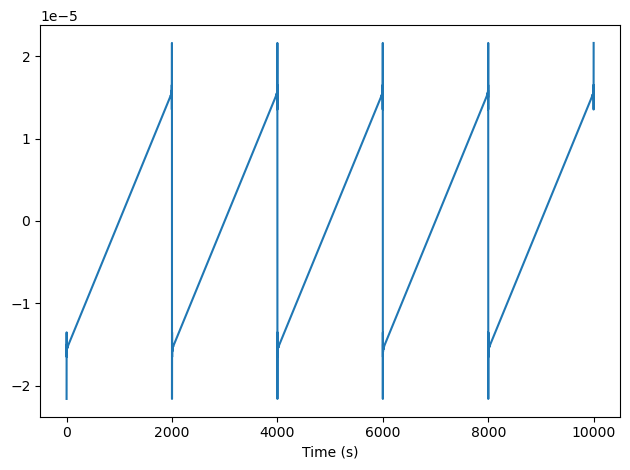

In [56]:
spectrum = in_wave.make_spectrum().differentiate().differentiate()
out_wave2 = spectrum.make_wave()
out_wave2.plot()
decorate(xlabel='Time (s)')

Окно второй разности равно -1, 2, -1. Вычисляя ДПФ окна, мы можем найти соответствующий фильтр

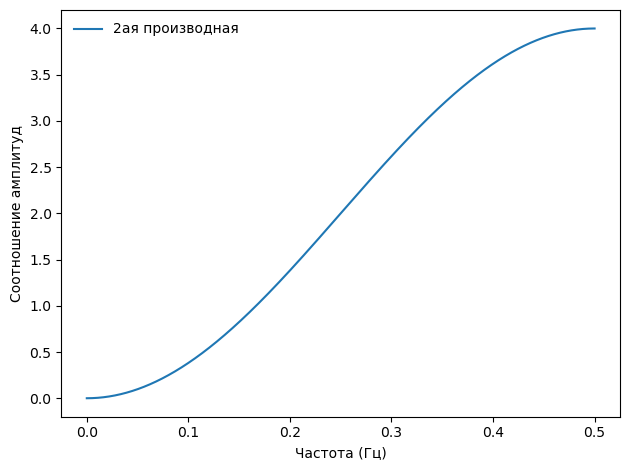

In [58]:
diff_window = np.array([-1.0, 2.0, -1.0])
padded = zero_pad(diff_window, len(in_wave))
diff_wave = Wave(padded, framerate=in_wave.framerate)
diff_filter = diff_wave.make_spectrum()
diff_filter.plot(label='2ая производная')

decorate(xlabel='Частота (Гц)', ylabel='Соотношение амплитуд')

Для второй прозводной мы можем найти соответствующий фильтр, вычислив фильтр первой производной и возведя его в квадратt.

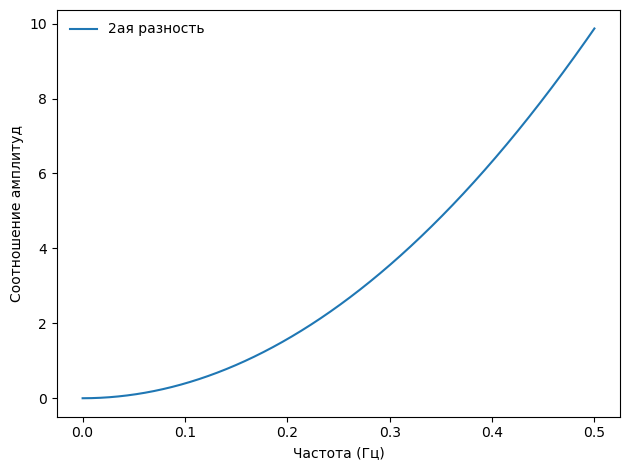

In [60]:
deriv_filter = in_wave.make_spectrum()
deriv_filter.hs = (np.pi * 2 * 1j * deriv_filter.fs)**2
deriv_filter.plot(label='2ая разность')

decorate(xlabel='Частота (Гц)', ylabel='Соотношение амплитуд')

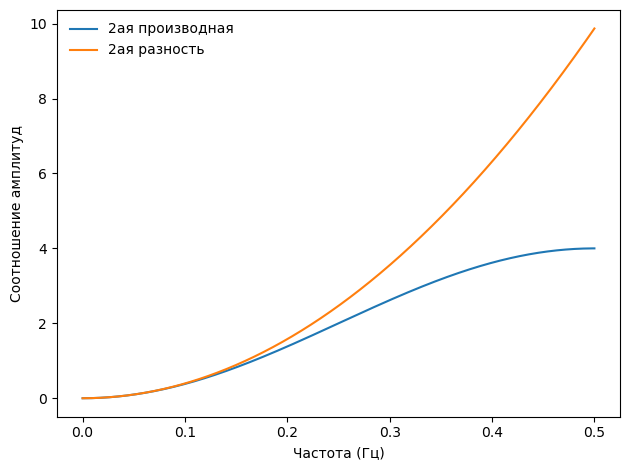

In [61]:
diff_filter.plot(label='2ая производная')
deriv_filter.plot(label='2ая разность')

decorate(xlabel='Частота (Гц)', ylabel='Соотношение амплитуд')

Оба являются фильтрами верхних частот, которые усиливают высокочастотные компоненты.
Вторая производная является параболической, поэтому она сильнее всего усиливает самые высокие частоты. Также она имеет хорошую аппроксимацию только на самых низких частотах, затем оно существенно отклоняется.